In [2]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [3]:
#Import the data and remove rows containing NAN values
df = pd.read_csv('Reliance_Stock.csv')
df = df.dropna()
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-06-08,453.399994,455.000000,441.549988,442.725006,425.550629,4958862.0
1,2015-06-09,441.774994,445.325012,438.674988,441.850006,424.709564,4184606.0
2,2015-06-10,443.000000,454.950012,442.500000,452.899994,435.330933,6176034.0
3,2015-06-11,453.000000,454.750000,436.825012,438.575012,421.561676,6709574.0
4,2015-06-12,439.500000,446.350006,439.125000,444.924988,427.665283,9849112.0


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1224,2020-06-01,1480.0,1538.349976,1475.949951,1520.349976,1520.349976,18434012.0
1225,2020-06-02,1526.0,1540.000000,1520.800049,1535.699951,1535.699951,10224049.0
1226,2020-06-03,1545.0,1560.000000,1533.349976,1541.650024,1541.650024,11713461.0
1227,2020-06-04,1544.0,1589.500000,1541.000000,1579.800049,1579.800049,15784379.0
1228,2020-06-05,1595.0,1618.000000,1573.699951,1581.699951,1581.699951,15246965.0


In [5]:
df_close = df['Close']

In [6]:
df_close.shape

(1228,)

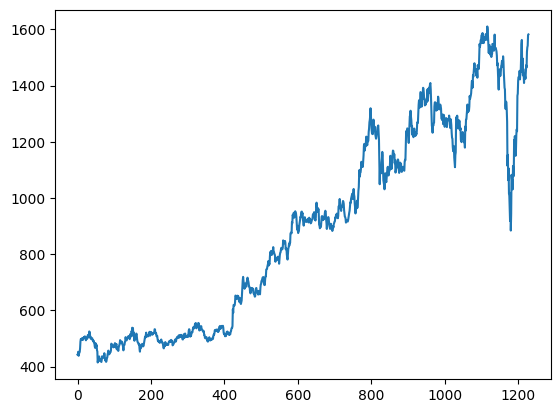

In [7]:
plt.plot(df_close)

In [9]:
scaler = MinMaxScaler(feature_range = (0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [10]:
df_close.shape

(1228, 1)

In [12]:
df_close

array([[0.02338571],
       [0.0226536 ],
       [0.0318991 ],
       ...,
       [0.94285362],
       [0.97477365],
       [0.97636329]])

In [13]:
#Split the data into train and test split
training_size = int(len(df_close) * 0.75)
test_size = len(df_close) - training_size
train_data, test_data = df_close[0:training_size,:], df_close[training_size:len(df_close),:1]

In [14]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [16]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [17]:
#Create the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
13/13 [==============================] - 7s 537ms/step - loss: 2.5166e-04 - val_loss: 0.0023
Epoch 2/100
13/13 [==============================] - 7s 573ms/step - loss: 2.5124e-04 - val_loss: 0.0020
Epoch 3/100
13/13 [==============================] - 7s 555ms/step - loss: 2.4821e-04 - val_loss: 0.0021
Epoch 4/100
13/13 [==============================] - 7s 562ms/step - loss: 2.5171e-04 - val_loss: 0.0024
Epoch 5/100
13/13 [==============================] - 8s 581ms/step - loss: 2.3123e-04 - val_loss: 0.0032
Epoch 6/100
13/13 [==============================] - 7s 561ms/step - loss: 2.4307e-04 - val_loss: 0.0029
Epoch 7/100
13/13 [==============================] - 8s 603ms/step - loss: 2.7639e-04 - val_loss: 0.0028
Epoch 8/100
13/13 [==============================] - 7s 565ms/step - loss: 2.7226e-04 - val_loss: 0.0019
Epoch 9/100
13/13 [==============================] - 8s 592ms/step - loss: 2.3559e-04 - val_loss: 0.0017
Epoch 10/100
13/13 [==============================] - 7

In [27]:
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [28]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [29]:
#Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train, train_predict))

815.8859132288046

In [30]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

1378.9809722847326

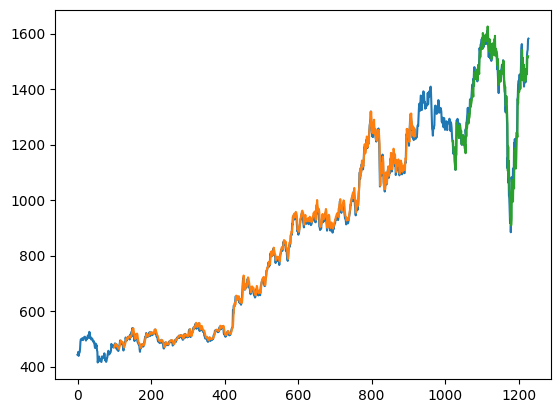

In [31]:
#Plotting

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_close) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [32]:
len(test_data), x_test.shape

(307, (206, 100, 1))

In [33]:
x_input = test_data[207:].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [35]:
lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.95384264]
101
1 day input [0.94816663 0.9478738  0.94456879 0.93260407 0.92796036 0.939716
 0.97577765 0.93507229 0.93636921 0.93590899 0.93047045 0.92603602
 0.91348555 0.88436843 0.89114567 0.8609409  0.83408293 0.81220327
 0.84642422 0.86491522 0.87269654 0.85249028 0.8541218  0.86847118
 0.88315526 0.88637653 0.89763007 0.88980697 0.88072882 0.91118463
 0.8962495  0.8619449  0.83805724 0.8176418  0.81283079 0.76463703
 0.75417831 0.7765181  0.77388248 0.74999482 0.71640139 0.5851654
 0.6181313  0.5423683  0.57776065 0.50279251 0.49634993 0.46330038
 0.42079615 0.50467508 0.39264125 0.44229929 0.55847473 0.54504569
 0.54454369 0.51513375 0.5848307  0.55696863 0.55445854 0.6620997
 0.65042781 0.67368794 0.64791772 0.61503546 0.63026342 0.67707661
 0.69364326 0.6882465  0.79387957 0.7999875  0.83855924 0.84922714
 0.84788844 0.84688434 0.86803608 0.84250843 0.86360165 0.86368529
 0.90198096 0.9474387  0.95987202 0.87902192 0.90503482 0.85441462
 0.87403524 0.85843081 0.83178201 0.8

In [36]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [37]:
len(df_close)

1228

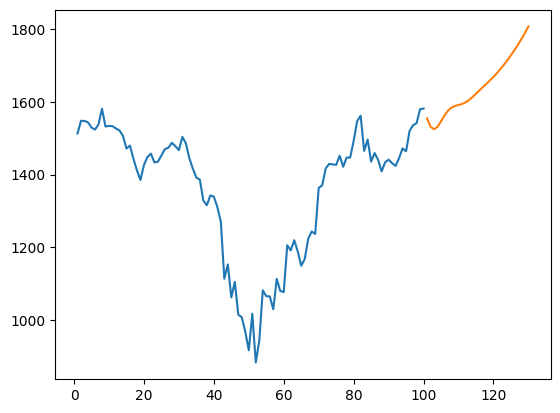

In [38]:
plt.plot(day_new, scaler.inverse_transform(df_close[1128:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))